In [2]:
import h5py
import os
import re
import numpy as np
from math import sqrt, log10, cos, sin, pi

# load data

In [3]:
data_root = "D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results"

def read_matlab_v73_file(label, batch, frame):
    file_path = os.path.join(data_root, f"Label_{label}/Batch_{batch}/Frame_{frame}/MTD_result.mat")
    with h5py.File(file_path, 'r') as f:
        var_names = list(f.keys())
        data = {}

        for var_name in var_names:
            # HDF5 中的数据是按列优先存储的，而 NumPy 是按行优先，因此需要转置
            if isinstance(f[var_name], h5py.Dataset):
                data[var_name] = np.array(f[var_name]).T

        return data

# visualize

In [4]:
def cfar_detector_2d(rd_matrix_db, detection_rows, detection_cols,
                      guard_range, guard_doppler, train_doppler,
                      threshold_factor_linear):
    """
    对RD矩阵的指定检测区域执行十字形CA-CFAR检测 (基于MATLAB版本).

    :param rd_matrix_db: 输入的RD矩阵 (dB).
    :param detection_rows: 需要检测的距离单元索引范围 (行).
    :param detection_cols: 需要检测的多普勒单元索引范围 (列).
    :param guard_range: 距离向保护单元数 (单侧).
    :param guard_doppler: 多普勒向保护单元数 (单侧).
    :param train_doppler: 多普勒向训练单元数 (单侧).
    :param threshold_factor_linear: 线性阈值因子.
    :return: 如果找到目标，返回一个应用了十字掩码的RD矩阵；否则返回None.
    """
    if rd_matrix_db.size == 0:
        return None

    num_rows, num_cols = rd_matrix_db.shape
    rd_matrix_linear = 10**(rd_matrix_db / 10.0)

    # 确保检测区域索引有效
    detection_rows = detection_rows[detection_rows < num_rows]
    detection_cols = detection_cols[detection_cols < num_cols]
    if len(detection_rows) == 0 or len(detection_cols) == 0:
        return None

    # 提取检测区域并排序
    col_indices, row_indices = np.meshgrid(detection_cols, detection_rows)
    detection_area_data = rd_matrix_linear[row_indices, col_indices]

    # 获取按幅度降序排列的索引
    sorted_flat_indices = np.argsort(detection_area_data.flatten())[::-1]

    # 遍历检测区域内的所有单元，从幅度最高的开始
    for flat_idx in sorted_flat_indices:
        r_local, c_local = np.unravel_index(flat_idx, detection_area_data.shape)

        # 转换为全局索引
        i = detection_rows[r_local]
        j = detection_cols[c_local]

        # --- 噪声估计 ---
        sum_noise = 0.0
        count_noise_cells = 0

        # 距离向参考单元
        range_ref_indices = np.concatenate((
            np.arange(0, i - guard_range),
            np.arange(i + guard_range + 1, num_rows)
        ))
        range_ref_indices = range_ref_indices[(range_ref_indices >= 0) & (range_ref_indices < num_rows)]

        if range_ref_indices.size > 0:
            sum_noise += np.sum(rd_matrix_linear[range_ref_indices, j])
            count_noise_cells += len(range_ref_indices)

        # 多普勒向参考单元
        doppler_ref_indices = np.concatenate((
            np.arange(j - guard_doppler - train_doppler, j - guard_doppler),
            np.arange(j + guard_doppler + 1, j + guard_doppler + train_doppler + 1)
        ))
        doppler_ref_indices = doppler_ref_indices[(doppler_ref_indices >= 0) & (doppler_ref_indices < num_cols)]

        if doppler_ref_indices.size > 0:
            sum_noise += np.sum(rd_matrix_linear[i, doppler_ref_indices])
            count_noise_cells += len(doppler_ref_indices)

        if count_noise_cells == 0:
            continue

        noise_average = sum_noise / count_noise_cells
        threshold = threshold_factor_linear * noise_average

        # --- 比较 ---
        if rd_matrix_linear[i, j] > threshold:
            # 找到目标，生成十字掩码
            mask = np.zeros_like(rd_matrix_db)
            peak_row, peak_col = i, j

            # 垂直部分: 目标列及左右各1列
            v_start_col = max(0, peak_col - 1)
            v_end_col = min(num_cols, peak_col + 2)
            mask[:, v_start_col:v_end_col] = 1

            # 水平部分: 目标行及上下各4行, 目标列左右各10列
            h_start_row = max(0, peak_row - 4)
            h_end_row = min(num_rows, peak_row + 5)
            h_start_col = max(0, peak_col - 10)
            h_end_col = min(num_cols, peak_col + 11)
            mask[h_start_row:h_end_row, h_start_col:h_end_col] = 1

            return rd_matrix_db * mask

    # 未找到目标
    return None

In [1]:
from matplotlib import pyplot as plt


def check_path(path):
    path = os.path.dirname(path)
    if not os.path.exists(path):
        os.makedirs(path)


def split_scientific_str(num, precision=10):
    """使用字符串格式化将一个数分成科学计数法的尾数和指数两部分"""
    scientific_str = f"{num:.{precision}e}"
    match = re.match(r'([+-]?\d+\.\d+)e([+-]?\d+)', scientific_str)
    if match:
        mantissa = float(match.group(1))
        exponent = int(match.group(2))
        return mantissa, exponent
    return num, 0


def visualize_rd_matrix(data, save_path=None, eps=1e-6, verbose=False):
    """可视化 RD 矩阵"""
    rd_matrix = data['rd_matrix']
    value = np.zeros_like(rd_matrix, dtype=np.float64)
    for i in range(len(rd_matrix)):
        for j in range(len(rd_matrix[i])):
            real = rd_matrix[i][j][0]
            real_mantissa, real_exponent = split_scientific_str(real)
            imag = rd_matrix[i][j][1]
            imag_mantissa, imag_exponent = split_scientific_str(imag)
            if real_exponent > imag_exponent:
                real_mantissa *= 10 ** (real_exponent - imag_exponent)
                value[i][j] = 10 * (log10(real_mantissa ** 2 + imag_mantissa ** 2 + eps) +  2 * imag_exponent)
            elif real_exponent < imag_exponent:
                imag_mantissa *= 10 ** (imag_exponent - real_exponent)
                value[i][j] = 20 * (log10(sqrt(real_mantissa ** 2 + imag_mantissa ** 2 + eps)) + real_exponent)
            else:
                value[i][j] = 20 * (log10(sqrt(real_mantissa ** 2 + imag_mantissa ** 2 + eps)) + real_exponent)

    range_axis = data['range_axis']
    velocity_axis = data['velocity_axis']

    velocity_index = np.where(np.reshape(velocity_axis, -1) == 0)[0][0]
    value[:, velocity_index-1:velocity_index+2] = 0

    # value[value < np.percentile(value, 5)] = 0

    if verbose:
        print(f"RD矩阵形状: {rd_matrix.shape}")

    plt.figure(figsize=(10, 8))

    X, Y = np.meshgrid(velocity_axis, range_axis)
    plt.pcolormesh(X, Y, value, shading='auto', cmap='jet')
    plt.xlim(-30, 30)
    plt.colorbar(label='Amplitude (dB)')
    plt.xlabel('velocity (m/s)')
    plt.ylabel('range (m)')
    plt.title('RD Map')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    if save_path:
        check_path(save_path)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

RD矩阵形状: (31, 360)


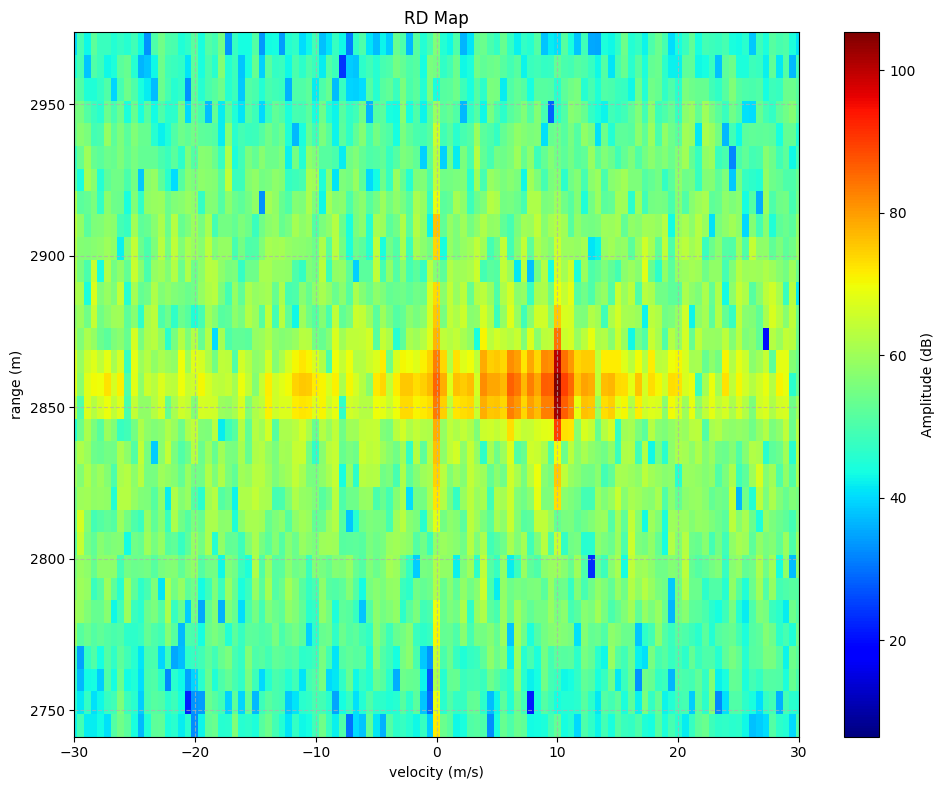

In [7]:
label = 2
batch = 1333
frame = 10

data = read_matlab_v73_file(label, batch, frame)
visualize_rd_matrix(data, verbose=True)

# 批量处理

In [4]:
import glob

In [4]:
label_dirs = glob.glob(f"{data_root}/Label_*")
image_sizes = []
for label_dir in label_dirs:
    label = int(label_dir.split("_")[-1])
    batch_dirs = glob.glob(f"{label_dir}/Batch_*")
    for batch_dir in batch_dirs:
        batch = int(batch_dir.split("_")[-1])
        frame_dirs = glob.glob(f"{batch_dir}/Frame_*")
        for frame_dir in frame_dirs:
            frame = int(frame_dir.split("_")[-1])
            data = read_matlab_v73_file(label, batch, frame)
            rd_matrix = data['rd_matrix']
            velocity_axis = data['velocity_axis']
            velocity_mask = np.reshape(np.abs(velocity_axis) < 56, -1)
            rd_matrix = rd_matrix[:, velocity_mask]
            image_size = rd_matrix.shape
            if image_size not in image_sizes:
                image_sizes.append(image_size)
print(image_sizes)

[(31, 53), (31, 65), (31, 201), (31, 217), (31, 503), (31, 545), (31, 319), (31, 345), (31, 47), (31, 141), (31, 127)]


In [12]:
import plotly.graph_objects as go

frame_nums = []
label_dirs = glob.glob(f"{data_root}/Label_*")
for label_dir in label_dirs:
    batch_dirs = glob.glob(f"{label_dir}/Batch_*")
    for batch_dir in batch_dirs:
        frame_dirs = glob.glob(f"{batch_dir}/Frame_*")
        frame_nums.append(len(frame_dirs))

fig = go.Figure(data=[go.Histogram(x=frame_nums, histnorm='probability', nbinsx=10)])
fig.update_layout(
    title_text="Frame Number Distribution",
    xaxis_title_text="Frame Number",
    yaxis_title_text="Probability",
    bargap=0.2,
    bargroupgap=0.1
)
fig.show()

In [15]:
count = 0
for frame_num in frame_nums:
    if frame_num > 64:
        count += 1
print(count / len(frame_nums))

0.48838709677419356


In [14]:
data_root = "E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results"
label_dirs = glob.glob(f"{data_root}/Label_*")
max_velocity = 0
for label_dir in label_dirs:
    batch_dirs = glob.glob(f"{label_dir}/Batch_*")
    for batch_dir in batch_dirs:
        frame_dirs = glob.glob(f"{batch_dir}/Frame_*")
        for frame_dir in frame_dirs:
            data = read_matlab_v73_file(label, batch, frame)
            velocity = abs(data["velocity"][0][0])
            if velocity > 30:
                print(frame_dir)
            max_velocity = max(max_velocity, velocity)
print(max_velocity)

E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_53
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_54
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_55
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_56
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_57
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_58
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_59
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_60
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_121\Frame_57
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_121\Frame_58
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_166\Frame_60
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_166\Frame_61
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_208\Frame_1
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_208\Fr

In [11]:
label = 1
batch = 1
frame = 1
file_path = f"E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results/Label_{label}/Batch_{batch}/Frame_{frame}/MTD_result.mat"
with h5py.File(file_path, 'r') as f:
    var_names = list(f.keys())
    data = {}

    for var_name in var_names:
        # HDF5 中的数据是按列优先存储的，而 NumPy 是按行优先，因此需要转置
        if isinstance(f[var_name], h5py.Dataset):
            data[var_name] = np.array(f[var_name]).T

In [14]:
rd_matrix = data["rd_matrix"]
value = np.zeros_like(rd_matrix, dtype=np.float64)
eps = 1e-10
for i in range(len(rd_matrix)):
    for j in range(len(rd_matrix[i])):
        real = rd_matrix[i][j][0]
        real_mantissa, real_exponent = split_scientific_str(real)
        imag = rd_matrix[i][j][1]
        imag_mantissa, imag_exponent = split_scientific_str(imag)
        if real_exponent > imag_exponent:
            real_mantissa *= 10 ** (real_exponent - imag_exponent)
            value[i][j] = 10 * (log10(real_mantissa ** 2 + imag_mantissa ** 2 + eps) +  2 * imag_exponent)
        elif real_exponent < imag_exponent:
            imag_mantissa *= 10 ** (imag_exponent - real_exponent)
            value[i][j] = 20 * (log10(sqrt(real_mantissa ** 2 + imag_mantissa ** 2 + eps)) + real_exponent)
        else:
            value[i][j] = 20 * (log10(sqrt(real_mantissa ** 2 + imag_mantissa ** 2 + eps)) + real_exponent)
velocity = data["velocity_axis"]
range_axis = data["range_axis"]

# 验证点迹多普勒速度和航迹速度的一致性

In [9]:
from tqdm import tqdm
import polars as pl


# 查找所有点迹文件
point_track_files = glob.glob(os.path.join(data_root, "../点迹", "PointTracks_*.txt"))
delta = []
for pt_file in tqdm(point_track_files, desc="处理原始数据"):
    re_result = re.match(r".*PointTracks_(\d+)_(\d+)_(\d+).txt", pt_file)
    batch = int(re_result.group(1))
    label = int(re_result.group(2))
    num_points = int(re_result.group(3))
    track_file = os.path.join(data_root, f"../航迹/Tracks_{batch}_{label}_{num_points}.txt")
    df_point = pl.read_csv(pt_file, has_header=True, separator=",", encoding="gbk")
    df_track = pl.read_csv(track_file, has_header=True, separator=",", encoding="gbk")
    df = df_point.join(df_track, on=["点时间", "批号"], how="left").sort("点时间")
    # 判断 df 中是否有 NaN 值
    if df.drop_nans().shape[0] != df.shape[0]:
        print(f"{track_file} 中有 NaN 值，跳过处理")
        continue
    for i in range(len(df)):
        v_x = df["X向速度"][i]
        v_y = df["Y向速度"][i]
        v_z = df["Z向速度"][i]
        theta = df["方位"][i] / 180 * pi
        phi = df["俯仰"][i] / 180 * pi
        doppler = df["多普勒速度"][i]
        pred_v = v_x * cos(phi) * cos(theta) + v_y * cos(phi) * sin(theta) + v_z * sin(phi)
        delta.append(abs(pred_v - doppler))
        if abs(pred_v - doppler) > 50:
            print(f"{track_file} 中第 {i+1} 个点迹与航迹速度差距过大，跳过处理")

处理原始数据:  17%|█▋        | 259/1550 [00:00<00:02, 632.71it/s]

D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_1625_6_15.txt 中第 7 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_193_1_20.txt 中第 20 个点迹与航迹速度差距过大，跳过处理


处理原始数据:  29%|██▉       | 448/1550 [00:00<00:01, 610.09it/s]

D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2125_6_18.txt 中第 12 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_231_1_19.txt 中第 8 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_234_1_12.txt 中有 NaN 值，跳过处理


处理原始数据:  41%|████      | 628/1550 [00:01<00:01, 575.35it/s]

D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2618_3_17.txt 中第 8 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2882_6_20.txt 中第 12 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2882_6_20.txt 中第 14 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2882_6_20.txt 中第 15 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2882_6_20.txt 中第 16 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2882_6_20.txt 中第 17 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2882_6_20.txt 中第 18 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2882_6_20.txt 中第 19 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_2882_6_20.txt 中第 20 个点迹与航迹速度差距过大，跳过处理


处理原始数据:  55%|█████▍    | 848/1550 [00:01<00:01, 506.78it/s]

D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_342_3_15.txt 中第 13 个点迹与航迹速度差距过大，跳过处理


处理原始数据:  86%|████████▋ | 1338/1550 [00:02<00:00, 399.03it/s]

D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_52_1_16.txt 中第 16 个点迹与航迹速度差距过大，跳过处理


处理原始数据:  97%|█████████▋| 1501/1550 [00:03<00:00, 399.94it/s]

D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_770_3_26.txt 中第 25 个点迹与航迹速度差距过大，跳过处理
D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\../航迹/Tracks_88_1_21.txt 中第 21 个点迹与航迹速度差距过大，跳过处理


处理原始数据: 100%|██████████| 1550/1550 [00:03<00:00, 480.91it/s]


In [8]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Histogram(x=delta, histnorm='probability', nbinsx=50)])
fig.update_layout(
    title_text="Delta Distribution",
    xaxis_title_text="Delta",
    yaxis_title_text="Probability",
    bargap=0.2,
    bargroupgap=0.1
)
fig.show()